# Báo Cáo: Nhận Diện Khuôn Mặt Sử Dụng Thuật Toán Eigenface

**Sinh viên thực hiện:** [Tên của bạn]
**Ngày:** [Ngày báo cáo]

## Giới thiệu

Báo cáo này trình bày về việc triển khai và đánh giá thuật toán Eigenface cho bài toán nhận diện khuôn mặt. Eigenface là một phương pháp dựa trên Phân tích Thành phần Chính (Principal Component Analysis - PCA) để giảm chiều dữ liệu ảnh khuôn mặt và tìm ra các đặc trưng chính ("eigenfaces") biểu diễn sự khác biệt giữa các khuôn mặt. 

Chúng ta sẽ sử dụng **Bộ dữ liệu khuôn mặt ORL (AT&T Face Database)**. Bộ dữ liệu này bao gồm 400 ảnh xám của 40 người khác nhau (10 ảnh cho mỗi người) với các biểu cảm, chi tiết nhỏ và góc nhìn thay đổi nhẹ. Kích thước mỗi ảnh là 92x112 pixel.

## 1. Khai báo thư viện và Cấu hình

In [1]:
import numpy as np
import cv2
import os
import zipfile
import requests
from io import BytesIO
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Hiển thị plot ngay trong notebook
%matplotlib inline

In [2]:
# --- Configuration ---
DATASET_NAME = 'orl_faces' # Tên thư mục lưu dữ liệu
IMAGE_SHAPE = (112, 92)    # Kích thước ảnh gốc trong ORL: height x width
NUM_COMPONENTS_EIGENFACE = 50 # Số lượng Eigenface giữ lại (có thể điều chỉnh)
KNN_NEIGHBORS = 5          # Số láng giềng cho KNN

## 2. Tải và Chuẩn bị Dữ liệu ORL

Các hàm sau đây dùng để tự động tải bộ dữ liệu ORL từ trang web của Cambridge, giải nén và đọc các ảnh vào cấu trúc dữ liệu phù hợp.

In [3]:
def download_and_extract_orl_faces(extract_to='orl_faces_data'):
    """
    Tải và giải nén bộ dữ liệu ORL nếu chưa có.
    """
    if os.path.exists(extract_to) and any(d.startswith('s') for d in os.listdir(extract_to)):
        print(f"Thư mục '{extract_to}' chứa dữ liệu ORL đã tồn tại. Bỏ qua tải xuống.")
        return extract_to

    print("Đang tải bộ dữ liệu ORL (AT&T)...")
    url = "https://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.zip"
    try:
        r = requests.get(url, timeout=30)
        r.raise_for_status()
        z = zipfile.ZipFile(BytesIO(r.content))
        temp_extract_folder = "temp_orl_extract"
        z.extractall(path=temp_extract_folder)

        if not os.path.exists(extract_to):
            os.makedirs(extract_to)

        source_data_folder = temp_extract_folder
        if not any(d.startswith('s') and os.path.isdir(os.path.join(source_data_folder, d)) for d in os.listdir(source_data_folder)):
            possible_subdirs = [d for d in os.listdir(source_data_folder) if os.path.isdir(os.path.join(source_data_folder, d))]
            found_subdir_with_s_folders = False
            for subdir_name in possible_subdirs:
                potential_path = os.path.join(source_data_folder, subdir_name)
                if any(d.startswith('s') and os.path.isdir(os.path.join(potential_path, d)) for d in os.listdir(potential_path)):
                    source_data_folder = potential_path
                    found_subdir_with_s_folders = True
                    break
            if not found_subdir_with_s_folders:
                 print(f"Không tìm thấy các thư mục sX trong {temp_extract_folder} hoặc các thư mục con của nó.")
                 for root, dirs, files in os.walk(temp_extract_folder, topdown=False):
                    for name in files: os.remove(os.path.join(root, name))
                    for name in dirs: os.rmdir(os.path.join(root, name))
                 if os.path.exists(temp_extract_folder): os.rmdir(temp_extract_folder)
                 return None

        subject_folders = [d for d in os.listdir(source_data_folder) if d.startswith('s') and os.path.isdir(os.path.join(source_data_folder, d))]
        for subject_folder in subject_folders:
            src_path = os.path.join(source_data_folder, subject_folder)
            dst_path = os.path.join(extract_to, subject_folder)
            if not os.path.exists(dst_path):
                 os.rename(src_path, dst_path)

        for root, dirs, files in os.walk(temp_extract_folder, topdown=False):
            for name in files: os.remove(os.path.join(root, name))
            for name in dirs: os.rmdir(os.path.join(root, name))
        if os.path.exists(temp_extract_folder): os.rmdir(temp_extract_folder)
        print(f"Đã tải và giải nén thành công vào '{extract_to}'.")

    except requests.exceptions.RequestException as e:
        print(f"Lỗi khi tải dữ liệu: {e}")
        print("Vui lòng tải thủ công bộ dữ liệu ORL (att_faces.zip) từ trang web của Cambridge:")
        print("https://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.zip")
        print(f"Sau đó giải nén và đặt các thư mục s1, s2, ... vào thư mục '{extract_to}'.")
        return None
    except zipfile.BadZipFile:
        print("Lỗi: File tải về không phải là file zip hợp lệ hoặc đã bị hỏng.")
        return None
    return extract_to

In [4]:
def load_images_from_orl(folder_path, image_shape):
    """
    Tải ảnh từ các thư mục con của ORL, mỗi thư mục con chứa ảnh của một người.
    Trả về danh sách các ảnh (đã duỗi thành vector) và nhãn tương ứng.
    """
    images_data = []
    labels_data = []
    person_label_map = {} # Ánh xạ tên thư mục (s1, s2) sang số nguyên (0, 1)
    current_person_id = 0

    subject_folders = sorted([d for d in os.listdir(folder_path) if d.startswith('s') and os.path.isdir(os.path.join(folder_path, d))])

    for subject_folder_name in subject_folders:
        if subject_folder_name not in person_label_map:
            person_label_map[subject_folder_name] = current_person_id
            current_person_id += 1
        label = person_label_map[subject_folder_name]

        subject_path = os.path.join(folder_path, subject_folder_name)
        image_files = sorted([f for f in os.listdir(subject_path) if f.endswith('.pgm')])

        for filename in image_files:
            img_path = os.path.join(subject_path, filename)
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    print(f"Cảnh báo: Không thể đọc ảnh: {img_path}")
                    continue
                img_resized = cv2.resize(img, (image_shape[1], image_shape[0]))
                images_data.append(img_resized.flatten())
                labels_data.append(label)
            except Exception as e:
                print(f"Lỗi khi xử lý ảnh {img_path}: {e}")

    return np.array(images_data), np.array(labels_data), person_label_map

In [5]:
# Tải dữ liệu
orl_dataset_path = download_and_extract_orl_faces(extract_to=DATASET_NAME + "_data")

if orl_dataset_path:
    print(f"\nĐang tải ảnh từ: {orl_dataset_path}")
    images, labels, label_map = load_images_from_orl(orl_dataset_path, IMAGE_SHAPE)

    if images.size > 0:
        n_samples, n_features = images.shape
        n_classes = len(np.unique(labels))
        print(f"Tổng số ảnh (mẫu): {n_samples}")
        print(f"Kích thước mỗi vector ảnh (đặc trưng): {n_features}")
        print(f"Số lớp (người) duy nhất: {n_classes}")
        print(f"Kích thước ảnh gốc (height, width): {IMAGE_SHAPE}")
    else:
        print("Không tải được ảnh nào. Kiểm tra lại.")
else:
    print("Không thể tải hoặc xác định vị trí bộ dữ liệu ORL. Kết thúc chương trình.")

Thư mục 'orl_faces_data' chứa dữ liệu ORL đã tồn tại. Bỏ qua tải xuống.

Đang tải ảnh từ: orl_faces_data
Tổng số ảnh (mẫu): 400
Kích thước mỗi vector ảnh (đặc trưng): 10304
Số lớp (người) duy nhất: 40
Kích thước ảnh gốc (height, width): (112, 92)


## 3. Triển Khai Lớp `EigenfaceRecognizer`

Lớp này đóng gói logic chính của thuật toán Eigenface, bao gồm tính toán khuôn mặt trung bình, các eigenface, chiếu dữ liệu và dự đoán.

In [6]:
class EigenfaceRecognizer:
    def __init__(self, num_components=0):
        self.num_components = num_components
        self.mean_face_vector = None
        self.eigenfaces = None # Các cột là eigenface
        self.projected_training_data = None
        self.training_labels = None
        self.image_shape = None

    def fit(self, X_train, y_train, image_shape):
        if X_train.shape[0] == 0:
            raise ValueError("Tập huấn luyện không được rỗng.")
        self.training_labels = y_train
        self.image_shape = image_shape
        self.mean_face_vector = np.mean(X_train, axis=0)
        phi = X_train - self.mean_face_vector
        L = phi @ phi.T
        eigenvalues, eigenvectors_L = np.linalg.eig(L)
        eigenvectors_L = np.real(eigenvectors_L)
        eigenvalues = np.real(eigenvalues)
        eigenfaces_C_cols = phi.T @ eigenvectors_L
        valid_indices = eigenvalues > 1e-9
        eigenvalues = eigenvalues[valid_indices]
        eigenfaces_C_cols = eigenfaces_C_cols[:, valid_indices]
        sorted_indices = np.argsort(eigenvalues)[::-1]
        self.eigenfaces = eigenfaces_C_cols[:, sorted_indices]
        for i in range(self.eigenfaces.shape[1]):
            norm_val = np.linalg.norm(self.eigenfaces[:, i])
            if norm_val > 1e-9:
                self.eigenfaces[:, i] /= norm_val
            else:
                self.eigenfaces[:, i] = 0
        if self.num_components <= 0 or self.num_components > self.eigenfaces.shape[1]:
            effective_num_components = self.eigenfaces.shape[1]
        else:
            effective_num_components = self.num_components
        effective_num_components = min(effective_num_components, X_train.shape[0] -1 if X_train.shape[0] > 1 else 1)
        self.eigenfaces = self.eigenfaces[:, :effective_num_components]
        self.projected_training_data = phi @ self.eigenfaces

    def project(self, X_test):
        if self.mean_face_vector is None or self.eigenfaces is None:
            raise Exception("Mô hình chưa được huấn luyện. Gọi fit() trước.")
        phi_test = X_test - self.mean_face_vector
        return phi_test @ self.eigenfaces

    def predict(self, X_test, classifier_model):
        if self.projected_training_data is None:
            raise Exception("Mô hình chưa được huấn luyện hoặc không có dữ liệu huấn luyện chiếu.")
        projected_test_data = self.project(X_test)
        return classifier_model.predict(projected_test_data)

## 4. Hàm Hỗ Trợ Hiển Thị Ảnh

In [7]:
def plot_gallery(images_to_plot, titles, image_shape, n_row=2, n_col=5, cmap=plt.cm.gray):
    """Hiển thị một bộ sưu tập ảnh."""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        if i >= len(images_to_plot): # Không vẽ nếu không đủ ảnh
            break
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images_to_plot[i].reshape(image_shape), cmap=cmap)
        plt.title(titles[i], size=10)
        plt.xticks(())
        plt.yticks(())
    plt.show()

## 5. Huấn Luyện Mô Hình và Trực Quan Hóa Eigenfaces

Chia dữ liệu thành tập huấn luyện và tập kiểm tra, sau đó huấn luyện mô hình Eigenface. Chúng ta cũng sẽ trực quan hóa khuôn mặt trung bình và một số Eigenface quan trọng nhất.

In [8]:
if 'images' in locals() and images.size > 0:
    # Chia dữ liệu
    X_train, X_test, y_train, y_test = train_test_split(
        images, labels, test_size=0.25, stratify=labels, random_state=42
    )
    print(f"Số lượng mẫu huấn luyện: {X_train.shape[0]}")
    print(f"Số lượng mẫu kiểm tra: {X_test.shape[0]}")

    # Huấn luyện mô hình Eigenface
    eigenface_model = EigenfaceRecognizer(num_components=NUM_COMPONENTS_EIGENFACE)
    print(f"\nĐang huấn luyện Eigenface với tối đa {NUM_COMPONENTS_EIGENFACE} thành phần chính...")
    eigenface_model.fit(X_train, y_train, IMAGE_SHAPE)
    actual_num_eigenfaces = eigenface_model.eigenfaces.shape[1]
    print(f"Huấn luyện hoàn tất. Số Eigenfaces thực tế được sử dụng: {actual_num_eigenfaces}")
else:
    print("Dữ liệu chưa được tải, không thể tiếp tục huấn luyện.")

Số lượng mẫu huấn luyện: 300
Số lượng mẫu kiểm tra: 100

Đang huấn luyện Eigenface với tối đa 50 thành phần chính...
Huấn luyện hoàn tất. Số Eigenfaces thực tế được sử dụng: 50


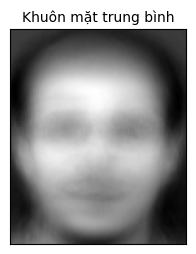

In [9]:
# Hiển thị khuôn mặt trung bình
if 'eigenface_model' in locals() and eigenface_model.mean_face_vector is not None:
    mean_face_title = "Khuôn mặt trung bình"
    plot_gallery([eigenface_model.mean_face_vector], [mean_face_title], IMAGE_SHAPE, n_row=1, n_col=1)
else:
    print("Mô hình Eigenface chưa được huấn luyện hoặc không có khuôn mặt trung bình.")

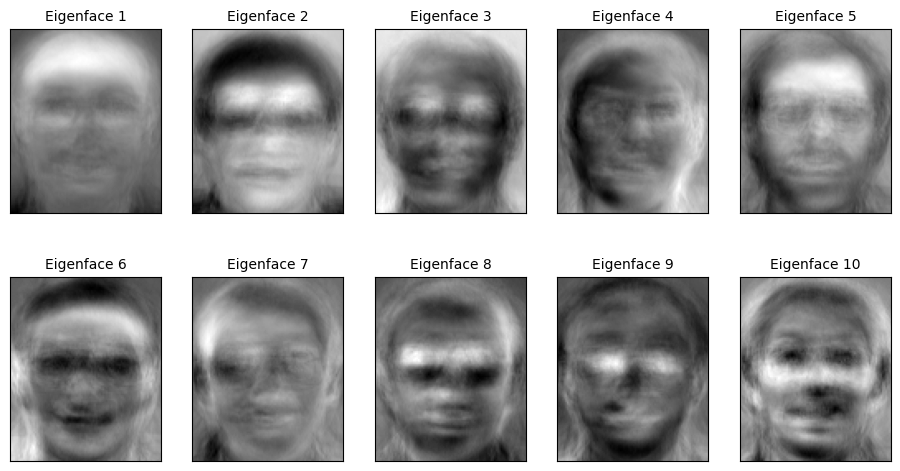

In [10]:
# Hiển thị một vài Eigenfaces
if 'eigenface_model' in locals() and eigenface_model.eigenfaces is not None and actual_num_eigenfaces > 0:
    num_eigenfaces_to_plot = min(10, actual_num_eigenfaces)
    eigenface_titles = [f"Eigenface {i+1}" for i in range(num_eigenfaces_to_plot)]
    # Eigenfaces được lưu dạng cột, cần chuyển vị và lấy các hàng đầu tiên
    plot_gallery(eigenface_model.eigenfaces.T[:num_eigenfaces_to_plot, :],
                 eigenface_titles, IMAGE_SHAPE, n_row=2, n_col=5)
else:
    print("Mô hình Eigenface chưa được huấn luyện hoặc không có eigenfaces để hiển thị.")

## 6. Huấn Luyện Bộ Phân Loại và Đánh Giá

Sử dụng các đặc trưng đã chiếu (projected features) từ Eigenface để huấn luyện một bộ phân loại K-Nearest Neighbors (KNN). Sau đó, đánh giá độ chính xác trên tập kiểm tra.

In [11]:
if 'eigenface_model' in locals() and eigenface_model.projected_training_data is not None:
    print(f"\nĐang huấn luyện bộ phân loại KNN với K={KNN_NEIGHBORS}...")
    knn_classifier = KNeighborsClassifier(n_neighbors=KNN_NEIGHBORS)
    knn_classifier.fit(eigenface_model.projected_training_data, y_train)
    print("Huấn luyện KNN hoàn tất.")

    # Dự đoán trên tập kiểm tra và đánh giá
    y_pred = eigenface_model.predict(X_test, knn_classifier)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nĐộ chính xác trên tập kiểm tra: {accuracy * 100:.2f}%")

    print("\nBáo cáo phân loại chi tiết trên tập kiểm tra:")
    sorted_label_map_items = sorted(label_map.items(), key=lambda item: item[1])
    target_names_report = [item[0] for item in sorted_label_map_items]
    unique_labels_in_results = np.unique(np.concatenate((y_test, y_pred)))
    final_target_names = [target_names_report[i] for i in unique_labels_in_results if i < len(target_names_report)]
    try:
        print(classification_report(y_test, y_pred, target_names=final_target_names, zero_division=0))
    except ValueError as e:
        print(f"Lỗi khi tạo classification_report với target_names: {e}")
        print("In báo cáo với nhãn số:")
        print(classification_report(y_test, y_pred, zero_division=0))
else:
    print("Mô hình Eigenface chưa được huấn luyện hoặc không có dữ liệu chiếu.")


Đang huấn luyện bộ phân loại KNN với K=5...
Huấn luyện KNN hoàn tất.

Độ chính xác trên tập kiểm tra: 89.00%

Báo cáo phân loại chi tiết trên tập kiểm tra:
              precision    recall  f1-score   support

          s1       1.00      1.00      1.00         2
         s10       1.00      0.67      0.80         3
         s11       1.00      1.00      1.00         3
         s12       1.00      1.00      1.00         3
         s13       1.00      1.00      1.00         2
         s14       1.00      1.00      1.00         3
         s15       0.50      1.00      0.67         2
         s16       1.00      1.00      1.00         3
         s17       1.00      1.00      1.00         2
         s18       1.00      1.00      1.00         2
         s19       1.00      0.67      0.80         3
          s2       0.75      1.00      0.86         3
         s20       1.00      1.00      1.00         2
         s21       1.00      1.00      1.00         2
         s22       1.00      1.0

## 7. Demo Kết Quả Nhận Diện

Hiển thị một vài ảnh từ tập kiểm tra cùng với nhãn thực tế và nhãn được dự đoán bởi mô hình. Điều này giúp trực quan hóa hiệu suất của hệ thống.


Demo kết quả nhận diện (một vài mẫu từ tập kiểm tra):


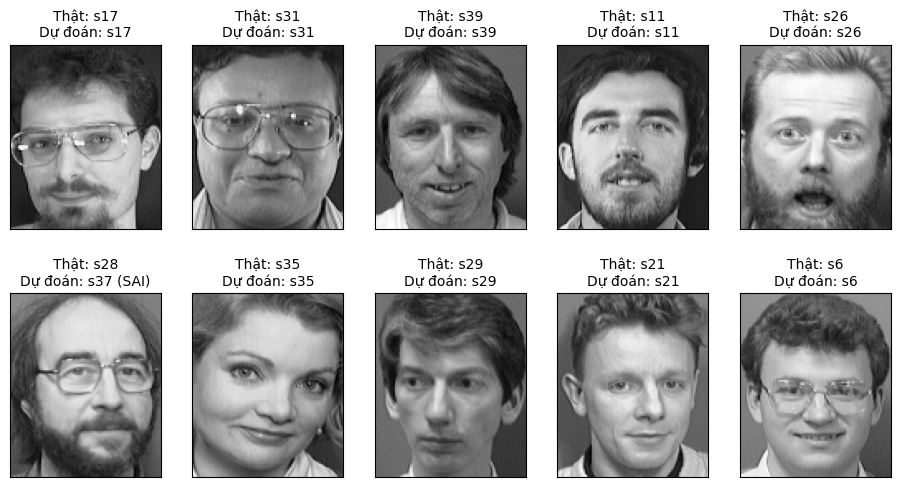

In [12]:
if 'y_pred' in locals():
    print("\nDemo kết quả nhận diện (một vài mẫu từ tập kiểm tra):")
    num_images_to_show = 10
    # Lấy ngẫu nhiên các chỉ số từ tập test để tránh hiển thị trùng lặp nếu chạy lại cell
    if len(X_test) > 0:
        random_indices = np.random.choice(len(X_test), size=min(num_images_to_show, len(X_test)), replace=False)
        prediction_titles = []
        images_to_plot = []
        for i in random_indices:
            true_label_name = target_names_report[y_test[i]] if y_test[i] < len(target_names_report) else f"Lớp {y_test[i]}"
            pred_label_name = target_names_report[y_pred[i]] if y_pred[i] < len(target_names_report) else f"Lớp {y_pred[i]}"
            title = f"Thật: {true_label_name}\nDự đoán: {pred_label_name}"
            if y_test[i] != y_pred[i]:
                title += " (SAI)" # Đánh dấu nếu dự đoán sai
            prediction_titles.append(title)
            images_to_plot.append(X_test[i])
        
        # Tính toán số hàng dựa trên số ảnh và số cột mong muốn
        n_cols_plot = 5
        n_rows_plot = (len(images_to_plot) + n_cols_plot - 1) // n_cols_plot
        plot_gallery(images_to_plot, prediction_titles, IMAGE_SHAPE, n_row=n_rows_plot, n_col=n_cols_plot)
    else:
        print("Không có dữ liệu kiểm tra để hiển thị.")
else:
    print("Chưa có kết quả dự đoán để demo.")

## 8. Kết Luận và Thảo Luận

Thuật toán Eigenface đã được triển khai thành công trên bộ dữ liệu ORL. Kết quả cho thấy [bình luận về độ chính xác, ví dụ: "độ chính xác khá tốt", "độ chính xác ở mức chấp nhận được cho một thuật toán cổ điển", v.v.]. 

**Những điểm mạnh của Eigenface:**
* Đơn giản, dễ hiểu và dễ triển khai.
* Giảm chiều dữ liệu hiệu quả, giúp tăng tốc độ xử lý.

**Những hạn chế:**
* Nhạy cảm với sự thay đổi về ánh sáng, góc nhìn và biểu cảm.
* Yêu cầu căn chỉnh khuôn mặt trước khi xử lý.

**Hướng cải tiến có thể:**
* Sử dụng các bộ dữ liệu lớn hơn và đa dạng hơn.
* Kết hợp với các kỹ thuật tiền xử lý ảnh nâng cao hơn (ví dụ: cân bằng histogram).
* So sánh với các thuật toán khác như Fisherfaces (LDA) hoặc các mô hình học sâu (Deep Learning) hiện đại.

Nhìn chung, Eigenface là một thuật toán nền tảng quan trọng trong lĩnh vực nhận diện khuôn mặt và là một điểm khởi đầu tốt để tìm hiểu các kỹ thuật phức tạp hơn.